<a href="https://colab.research.google.com/github/ameyas1/Medical-Diagnosis/blob/master/My_Medical_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Utils**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)


def get_true_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def get_true_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def get_false_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def get_false_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))


def get_performance_metrics(y, pred, class_labels, tp=get_true_pos,
                            tn=get_true_neg, fp=get_false_pos,
                            fn=get_false_neg,
                            acc=None, prevalence=None, spec=None,
                            sens=None, ppv=None, npv=None, auc=None, f1=None,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round(tp(y[:, i], pred[:, i]),
                             3) if tp != None else "Not Defined"
        df.loc[i][2] = round(tn(y[:, i], pred[:, i]),
                             3) if tn != None else "Not Defined"
        df.loc[i][3] = round(fp(y[:, i], pred[:, i]),
                             3) if fp != None else "Not Defined"
        df.loc[i][4] = round(fn(y[:, i], pred[:, i]),
                             3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]),
                              3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df


def print_confidence_intervals(class_labels, statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    for i in range(len(class_labels)):
        mean = statistics.mean(axis=1)[i]
        max_ = np.quantile(statistics, .95, axis=1)[i]
        min_ = np.quantile(statistics, .05, axis=1)[i]
        df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df


def get_curve(gt, pred, target_names, curve='roc'):
    for i in range(len(target_names)):
        if curve == 'roc':
            curve_function = roc_curve
            auc_roc = roc_auc_score(gt[:, i], pred[:, i])
            label = target_names[i] + " AUC: %.3f " % auc_roc
            xlabel = "False positive rate"
            ylabel = "True positive rate"
            a, b, _ = curve_function(gt[:, i], pred[:, i])
            plt.figure(1, figsize=(7, 7))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(a, b, label=label)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        elif curve == 'prc':
            precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
            average_precision = average_precision_score(gt[:, i], pred[:, i])
            label = target_names[i] + " Avg.: %.3f " % average_precision
            plt.figure(1, figsize=(7, 7))
            plt.step(recall, precision, where='post', label=label)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)

**preprocess**

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import tensorflow as tf

In [3]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tensorflow.keras.models import load_model

In [4]:
from tensorflow.keras.preprocessing import image

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
df = pd.read_csv("/content/drive/My Drive/medical_test.csv")

In [7]:
df=df[df['No Finding'] != 1]
df.drop(['No Finding'], axis =1, inplace =True)
df.drop(['Unnamed: 0'], axis=1,inplace=True)

In [8]:
df.head()

,Image Index,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Patient ID
2,00000013_001.png,0,0,0,0,0,1,0,0,0,0,0,0,0,1,13
3,00000013_002.png,0,0,0,0,0,1,0,0,0,0,0,0,0,1,13
4,00000013_003.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,13
5,00000013_004.png,0,0,0,0,1,1,0,0,1,0,0,0,0,1,13
6,00000013_005.png,0,0,0,0,0,1,0,0,1,0,0,1,0,1,13


In [9]:
imgs = df['Image Index'].tolist()

In [10]:
imgs[:3]

['00000013_001.png', '00000013_002.png', '00000013_003.png']

In [11]:
files=[1,2,3]
import tarfile
for idx, _ in enumerate(files):
  fn = '/content/drive/My Drive/images_%02d.tar.gz' % (idx+1)
  print('unzipping', fn, '...')
  tar = tarfile.open(fn, "r:gz")
  tar.extractall('/content/')
  tar.close()

unzipping /content/drive/My Drive/images_01.tar.gz ...
unzipping /content/drive/My Drive/images_02.tar.gz ...
unzipping /content/drive/My Drive/images_03.tar.gz ...


In [12]:
import os
IMG_DIR = "/content/images"

In [13]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [14]:
pred_labels = [l + "_pred" for l in labels]

In [15]:
pred_labels

['Cardiomegaly_pred',
 'Emphysema_pred',
 'Effusion_pred',
 'Hernia_pred',
 'Infiltration_pred',
 'Mass_pred',
 'Nodule_pred',
 'Atelectasis_pred',
 'Pneumothorax_pred',
 'Pleural_Thickening_pred',
 'Pneumonia_pred',
 'Fibrosis_pred',
 'Edema_pred',
 'Consolidation_pred']

In [16]:
column_names = ['Image Index']+pred_labels

In [17]:
print(column_names)

['Image Index', 'Cardiomegaly_pred', 'Emphysema_pred', 'Effusion_pred', 'Hernia_pred', 'Infiltration_pred', 'Mass_pred', 'Nodule_pred', 'Atelectasis_pred', 'Pneumothorax_pred', 'Pleural_Thickening_pred', 'Pneumonia_pred', 'Fibrosis_pred', 'Edema_pred', 'Consolidation_pred']


In [57]:
df_pred = pd.DataFrame(columns = column_names)


In [58]:
df_pred

,Image Index,Cardiomegaly_pred,Emphysema_pred,Effusion_pred,Hernia_pred,Infiltration_pred,Mass_pred,Nodule_pred,Atelectasis_pred,Pneumothorax_pred,Pleural_Thickening_pred,Pneumonia_pred,Fibrosis_pred,Edema_pred,Consolidation_pred


In [20]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(320,320,3), pooling=None)
x = base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x) 
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.LayerNormalization()(x)
x=tf.keras.layers.Dropout(0.2)(x)

x=tf.keras.layers.Dense(64,activation='relu')(x)
x=tf.keras.layers.LayerNormalization()(x)
x=tf.keras.layers.Dropout(0.2)(x)

# x=tf.keras.layers.Dense(16,activation='relu')(x)
# x=tf.keras.layers.LayerNormalization()(x)
# x=tf.keras.layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
predictions = tf.keras.layers.Dense  (len(labels), activation='softmax')(x)           

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

29089792/29084464 [==============================] - 0s 0us/step


In [21]:
# set all layers trainable by default
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.9

In [22]:
for layer in model.layers[:-250]:
    # fix all but batch norm layers, because we neeed to update moving averages for a new dataset!
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

In [23]:
model.load_weights('/content/drive/My Drive/medical.hdf5')

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 160, 160, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [59]:
H=W=320
for ind, img_p in enumerate(imgs):
  img_path = os.path.join(IMG_DIR,img_p)
  img = image.load_img(img_path, target_size=(H, W))
  mean = np.mean(img)
  std = np.std(img)
  img -= mean
  if std!=0:
    img /= std
  img = np.expand_dims(img, axis=0)
  pred=model.predict(img)[0]
  item= [img_p] + pred.astype(np.float).tolist()
  df_pred.loc[ind] = item




In [60]:
df_pred

,Image Index,Cardiomegaly_pred,Emphysema_pred,Effusion_pred,Hernia_pred,Infiltration_pred,Mass_pred,Nodule_pred,Atelectasis_pred,Pneumothorax_pred,Pleural_Thickening_pred,Pneumonia_pred,Fibrosis_pred,Edema_pred,Consolidation_pred
0,00000013_001.png,7.205974e-06,5.493302e-01,0.000024,1.214255e-08,7.844157e-05,6.211487e-06,0.000014,0.000043,0.450447,9.161127e-06,4.176663e-08,5.521561e-08,1.181907e-06,3.973921e-05
1,00000013_002.png,1.964880e-05,5.667576e-01,0.000044,6.922485e-08,7.356102e-05,4.827149e-05,0.000006,0.000118,0.432884,7.795688e-07,5.372669e-09,1.378317e-08,2.287756e-06,4.621110e-05
2,00000013_003.png,7.442359e-07,6.304183e-04,0.000051,3.082444e-07,4.337404e-08,1.719166e-06,0.000026,0.000037,0.000005,9.992456e-01,1.288745e-07,1.079738e-06,1.277874e-08,9.198394e-08
3,00000013_004.png,5.499734e-04,2.602371e-01,0.253414,3.085908e-08,2.181097e-01,4.078007e-05,0.000128,0.007710,0.258513,1.892317e-05,7.919472e-07,3.415132e-07,1.021255e-04,1.175594e-03
4,00000013_005.png,4.383061e-05,1.148690e-01,0.000366,3.414327e-08,3.638370e-01,2.032825e-07,0.000335,0.000381,0.507719,1.140615e-02,1.208809e-05,9.316230e-04,2.827944e-07,9.890163e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,00006425_024.png,2.144917e-08,1.612247e-07,0.000170,5.780119e-12,4.284482e-01,1.604235e-03,0.000003,0.000058,0.000564,1.067819e-07,2.193410e-07,2.528618e-08,6.837896e-06,5.691462e-01
311,00006425_025.png,1.916137e-06,3.249838e-04,0.000008,7.164247e-07,2.676552e-01,3.628153e-01,0.004642,0.000261,0.363735,7.897389e-07,6.627485e-08,2.365740e-05,3.004447e-06,5.280991e-04
312,00006425_026.png,2.641171e-07,2.591764e-05,0.000004,1.504116e-07,1.735986e-04,5.028681e-01,0.000041,0.000067,0.496153,3.783445e-06,1.966560e-09,9.619703e-07,1.266832e-07,6.617022e-04
313,00006425_027.png,7.363891e-04,3.379351e-01,0.000114,5.367385e-08,2.763812e-05,2.543076e-04,0.000021,0.000031,0.290238,1.236417e-05,3.695279e-05,9.853522e-07,2.685682e-01,1.020235e-01


In [61]:
df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Image Index,,,,,,,,,,,,,,
00000013_001.png,0,0,0,0,0,1,0,0,0,0,0,0,0,1
00000013_002.png,0,0,0,0,0,1,0,0,0,0,0,0,0,1
00000013_003.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0
00000013_004.png,0,0,0,0,1,1,0,0,1,0,0,0,0,1
00000013_005.png,0,0,0,0,0,1,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00006425_024.png,0,0,1,0,0,0,0,0,1,0,0,0,0,0
00006425_025.png,0,0,0,0,0,0,0,0,1,1,0,0,0,1
00006425_026.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [63]:
df.set_index('Image Index', inplace=True)
df_pred.set_index('Image Index', inplace=True)


In [65]:
df.drop(['Patient ID'], axis =1, inplace =True)

In [30]:
df.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Image Index,,,,,,,,,,,,,,
00000013_001.png,0,0,0,0,0,1,0,0,0,0,0,0,0,1
00000013_002.png,0,0,0,0,0,1,0,0,0,0,0,0,0,1
00000013_003.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0
00000013_004.png,0,0,0,0,1,1,0,0,1,0,0,0,0,1
00000013_005.png,0,0,0,0,0,1,0,0,1,0,0,1,0,1


In [66]:
df_pred.head()

,Cardiomegaly_pred,Emphysema_pred,Effusion_pred,Hernia_pred,Infiltration_pred,Mass_pred,Nodule_pred,Atelectasis_pred,Pneumothorax_pred,Pleural_Thickening_pred,Pneumonia_pred,Fibrosis_pred,Edema_pred,Consolidation_pred
Image Index,,,,,,,,,,,,,,
00000013_001.png,7.205974e-06,0.549330,0.000024,1.214255e-08,7.844157e-05,6.211487e-06,0.000014,0.000043,0.450447,9.161127e-06,4.176663e-08,5.521561e-08,1.181907e-06,3.973921e-05
00000013_002.png,1.964880e-05,0.566758,0.000044,6.922485e-08,7.356102e-05,4.827149e-05,0.000006,0.000118,0.432884,7.795688e-07,5.372669e-09,1.378317e-08,2.287756e-06,4.621110e-05
00000013_003.png,7.442359e-07,0.000630,0.000051,3.082444e-07,4.337404e-08,1.719166e-06,0.000026,0.000037,0.000005,9.992456e-01,1.288745e-07,1.079738e-06,1.277874e-08,9.198394e-08
00000013_004.png,5.499734e-04,0.260237,0.253414,3.085908e-08,2.181097e-01,4.078007e-05,0.000128,0.007710,0.258513,1.892317e-05,7.919472e-07,3.415132e-07,1.021255e-04,1.175594e-03
00000013_005.png,4.383061e-05,0.114869,0.000366,3.414327e-08,3.638370e-01,2.032825e-07,0.000335,0.000381,0.507719,1.140615e-02,1.208809e-05,9.316230e-04,2.827944e-07,9.890163e-05


In [67]:
final_df = df.merge(df_pred, left_index=True, right_index=True)

In [68]:
final_df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Cardiomegaly_pred,Emphysema_pred,Effusion_pred,Hernia_pred,Infiltration_pred,Mass_pred,Nodule_pred,Atelectasis_pred,Pneumothorax_pred,Pleural_Thickening_pred,Pneumonia_pred,Fibrosis_pred,Edema_pred,Consolidation_pred
Image Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00000013_001.png,0,0,0,0,0,1,0,0,0,0,0,0,0,1,7.205974e-06,5.493302e-01,0.000024,1.214255e-08,7.844157e-05,6.211487e-06,0.000014,0.000043,0.450447,9.161127e-06,4.176663e-08,5.521561e-08,1.181907e-06,3.973921e-05
00000013_002.png,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1.964880e-05,5.667576e-01,0.000044,6.922485e-08,7.356102e-05,4.827149e-05,0.000006,0.000118,0.432884,7.795688e-07,5.372669e-09,1.378317e-08,2.287756e-06,4.621110e-05
00000013_003.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,7.442359e-07,6.304183e-04,0.000051,3.082444e-07,4.337404e-08,1.719166e-06,0.000026,0.000037,0.000005,9.992456e-01,1.288745e-07,1.079738e-06,1.277874e-08,9.198394e-08
00000013_004.png,0,0,0,0,1,1,0,0,1,0,0,0,0,1,5.499734e-04,2.602371e-01,0.253414,3.085908e-08,2.181097e-01,4.078007e-05,0.000128,0.007710,0.258513,1.892317e-05,7.919472e-07,3.415132e-07,1.021255e-04,1.175594e-03
00000013_005.png,0,0,0,0,0,1,0,0,1,0,0,1,0,1,4.383061e-05,1.148690e-01,0.000366,3.414327e-08,3.638370e-01,2.032825e-07,0.000335,0.000381,0.507719,1.140615e-02,1.208809e-05,9.316230e-04,2.827944e-07,9.890163e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00006425_024.png,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2.144917e-08,1.612247e-07,0.000170,5.780119e-12,4.284482e-01,1.604235e-03,0.000003,0.000058,0.000564,1.067819e-07,2.193410e-07,2.528618e-08,6.837896e-06,5.691462e-01
00006425_025.png,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1.916137e-06,3.249838e-04,0.000008,7.164247e-07,2.676552e-01,3.628153e-01,0.004642,0.000261,0.363735,7.897389e-07,6.627485e-08,2.365740e-05,3.004447e-06,5.280991e-04
00006425_026.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2.641171e-07,2.591764e-05,0.000004,1.504116e-07,1.735986e-04,5.028681e-01,0.000041,0.000067,0.496153,3.783445e-06,1.966560e-09,9.619703e-07,1.266832e-07,6.617022e-04


In [69]:
final_df.reset_index(drop=True, inplace=True)

In [70]:
final_df.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Cardiomegaly_pred,Emphysema_pred,Effusion_pred,Hernia_pred,Infiltration_pred,Mass_pred,Nodule_pred,Atelectasis_pred,Pneumothorax_pred,Pleural_Thickening_pred,Pneumonia_pred,Fibrosis_pred,Edema_pred,Consolidation_pred
0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,7.205974e-06,0.549330,0.000024,1.214255e-08,7.844157e-05,6.211487e-06,0.000014,0.000043,0.450447,9.161127e-06,4.176663e-08,5.521561e-08,1.181907e-06,3.973921e-05
1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1.964880e-05,0.566758,0.000044,6.922485e-08,7.356102e-05,4.827149e-05,0.000006,0.000118,0.432884,7.795688e-07,5.372669e-09,1.378317e-08,2.287756e-06,4.621110e-05
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,7.442359e-07,0.000630,0.000051,3.082444e-07,4.337404e-08,1.719166e-06,0.000026,0.000037,0.000005,9.992456e-01,1.288745e-07,1.079738e-06,1.277874e-08,9.198394e-08
3,0,0,0,0,1,1,0,0,1,0,0,0,0,1,5.499734e-04,0.260237,0.253414,3.085908e-08,2.181097e-01,4.078007e-05,0.000128,0.007710,0.258513,1.892317e-05,7.919472e-07,3.415132e-07,1.021255e-04,1.175594e-03
4,0,0,0,0,0,1,0,0,1,0,0,1,0,1,4.383061e-05,0.114869,0.000366,3.414327e-08,3.638370e-01,2.032825e-07,0.000335,0.000381,0.507719,1.140615e-02,1.208809e-05,9.316230e-04,2.827944e-07,9.890163e-05


In [71]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Atelectasis              315 non-null    int64  
 1   Cardiomegaly             315 non-null    int64  
 2   Consolidation            315 non-null    int64  
 3   Edema                    315 non-null    int64  
 4   Effusion                 315 non-null    int64  
 5   Emphysema                315 non-null    int64  
 6   Fibrosis                 315 non-null    int64  
 7   Hernia                   315 non-null    int64  
 8   Infiltration             315 non-null    int64  
 9   Mass                     315 non-null    int64  
 10  Nodule                   315 non-null    int64  
 11  Pleural_Thickening       315 non-null    int64  
 12  Pneumonia                315 non-null    int64  
 13  Pneumothorax             315 non-null    int64  
 14  Cardiomegaly_pred        3

In [101]:
final_df.to_csv('test_merged.csv')

In [103]:
df_t = pd.read_csv("/content/drive/My Drive/medical_train.csv")
df_t=df_t[df_t['No Finding'] != 1]
df_t.drop(['No Finding'], axis =1, inplace =True)
df_t.drop(['Unnamed: 0'], axis=1,inplace=True)

In [104]:
df_t.head()

,Image Index,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Patient ID
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
2,00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
3,00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3
4,00000003_001.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3


In [105]:
imgs_t = df_t['Image Index'].tolist()

In [106]:
imgs_t[:3]

['00000001_000.png', '00000001_001.png', '00000001_002.png']

In [107]:
print(column_names)

['Image Index', 'Cardiomegaly_pred', 'Emphysema_pred', 'Effusion_pred', 'Hernia_pred', 'Infiltration_pred', 'Mass_pred', 'Nodule_pred', 'Atelectasis_pred', 'Pneumothorax_pred', 'Pleural_Thickening_pred', 'Pneumonia_pred', 'Fibrosis_pred', 'Edema_pred', 'Consolidation_pred']


In [108]:
df_t_pred = pd.DataFrame(columns = column_names)

In [111]:
df_t_pred

,Image Index,Cardiomegaly_pred,Emphysema_pred,Effusion_pred,Hernia_pred,Infiltration_pred,Mass_pred,Nodule_pred,Atelectasis_pred,Pneumothorax_pred,Pleural_Thickening_pred,Pneumonia_pred,Fibrosis_pred,Edema_pred,Consolidation_pred


In [112]:
H=W=320
for ind, img_p in enumerate(imgs_t):
  img_path = os.path.join(IMG_DIR,img_p)
  img = image.load_img(img_path, target_size=(H, W))
  mean = np.mean(img)
  std = np.std(img)
  img -= mean
  if std!=0:
    img /= std
  img = np.expand_dims(img, axis=0)
  pred=model.predict(img)[0]
  item= [img_p] + pred.astype(np.float).tolist()
  df_t_pred.loc[ind] = item

In [113]:
df_t.set_index('Image Index', inplace=True)
df_t_pred.set_index('Image Index', inplace=True)
df_t.drop(['Patient ID'], axis =1, inplace =True)

In [114]:
df_t.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Image Index,,,,,,,,,,,,,,
00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0
00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0
00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0
00000003_001.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [115]:
df_t_pred.head()

,Cardiomegaly_pred,Emphysema_pred,Effusion_pred,Hernia_pred,Infiltration_pred,Mass_pred,Nodule_pred,Atelectasis_pred,Pneumothorax_pred,Pleural_Thickening_pred,Pneumonia_pred,Fibrosis_pred,Edema_pred,Consolidation_pred
Image Index,,,,,,,,,,,,,,
00000001_000.png,0.999946,0.000011,1.921464e-05,1.714710e-07,1.092857e-05,1.494018e-08,0.000001,0.000001,4.109165e-07,1.505973e-10,7.965946e-11,2.069648e-07,1.014594e-05,1.247788e-07
00000001_001.png,0.487119,0.510186,3.515588e-05,7.633032e-05,6.130301e-07,6.115753e-06,0.000010,0.000021,2.501540e-03,3.338341e-07,1.307612e-09,1.691427e-06,3.791699e-05,3.486931e-06
00000001_002.png,0.551650,0.000004,4.482535e-01,6.015648e-09,2.738633e-05,2.922762e-07,0.000001,0.000037,4.603417e-06,8.068188e-07,6.428245e-09,4.461774e-07,1.623048e-05,4.248983e-06
00000003_000.png,0.001345,0.000116,7.370102e-09,9.984367e-01,7.342195e-09,2.682147e-06,0.000034,0.000005,3.497651e-08,2.737039e-09,2.129151e-08,6.017965e-05,2.804842e-07,5.251860e-11
00000003_001.png,0.000885,0.000094,1.208932e-08,9.982145e-01,1.510732e-07,4.160204e-07,0.000065,0.000042,1.913323e-08,5.108074e-09,1.216988e-07,6.986959e-04,1.238961e-07,9.472296e-11


In [116]:
final_df_train = df_t.merge(df_t_pred, left_index=True, right_index=True)

In [117]:
final_df_train.tail()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Cardiomegaly_pred,Emphysema_pred,Effusion_pred,Hernia_pred,Infiltration_pred,Mass_pred,Nodule_pred,Atelectasis_pred,Pneumothorax_pred,Pleural_Thickening_pred,Pneumonia_pred,Fibrosis_pred,Edema_pred,Consolidation_pred
Image Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00006500_007.png,1,0,0,0,1,0,0,0,0,0,0,0,0,0,8.692336e-06,6.484466e-07,5.005234e-01,1.517248e-08,0.000040,4.850115e-05,5.106448e-08,0.499346,1.913474e-06,1.778777e-06,1.527093e-08,9.038603e-09,1.044441e-07,2.875478e-05
00006500_008.png,0,0,1,0,0,0,0,0,1,0,0,0,0,0,4.175356e-08,6.695793e-09,2.622358e-05,7.890366e-14,0.424626,5.044230e-07,1.999456e-06,0.000001,5.273558e-05,1.294707e-07,1.094838e-06,6.915863e-07,2.863054e-06,5.752869e-01
00006500_009.png,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3.409711e-07,5.630349e-09,9.999559e-01,2.951972e-12,0.000018,3.033592e-06,5.668010e-08,0.000016,2.372658e-07,7.476527e-07,1.128030e-09,4.774540e-10,8.682369e-08,5.832164e-06
00006500_010.png,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4.585573e-07,5.753509e-10,9.999732e-01,9.308039e-12,0.000008,6.553332e-07,1.316442e-08,0.000007,3.276813e-06,4.286631e-06,1.014152e-09,2.446991e-08,3.336368e-09,2.233842e-06
00006500_011.png,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.605872e-08,1.744363e-09,5.443206e-07,2.350816e-12,0.999994,4.319944e-09,9.524570e-07,0.000002,8.556994e-08,1.904100e-09,2.408457e-07,1.642626e-06,1.163283e-08,3.613344e-07


In [118]:
final_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9733 entries, 00000001_000.png to 00006500_011.png
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Atelectasis              9733 non-null   int64  
 1   Cardiomegaly             9733 non-null   int64  
 2   Consolidation            9733 non-null   int64  
 3   Edema                    9733 non-null   int64  
 4   Effusion                 9733 non-null   int64  
 5   Emphysema                9733 non-null   int64  
 6   Fibrosis                 9733 non-null   int64  
 7   Hernia                   9733 non-null   int64  
 8   Infiltration             9733 non-null   int64  
 9   Mass                     9733 non-null   int64  
 10  Nodule                   9733 non-null   int64  
 11  Pleural_Thickening       9733 non-null   int64  
 12  Pneumonia                9733 non-null   int64  
 13  Pneumothorax             9733 non-null   int64  
 14  Ca

In [119]:
df_t.shape, final_df_train.shape

((9733, 14), (9733, 28))

In [120]:
final_df_train.reset_index(drop=True, inplace=True)

In [121]:
final_df_train.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Cardiomegaly_pred,Emphysema_pred,Effusion_pred,Hernia_pred,Infiltration_pred,Mass_pred,Nodule_pred,Atelectasis_pred,Pneumothorax_pred,Pleural_Thickening_pred,Pneumonia_pred,Fibrosis_pred,Edema_pred,Consolidation_pred
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.999946,0.000011,1.921464e-05,1.714710e-07,1.092857e-05,1.494018e-08,0.000001,0.000001,4.109165e-07,1.505973e-10,7.965946e-11,2.069648e-07,1.014594e-05,1.247788e-07
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.487119,0.510186,3.515588e-05,7.633032e-05,6.130301e-07,6.115753e-06,0.000010,0.000021,2.501540e-03,3.338341e-07,1.307612e-09,1.691427e-06,3.791699e-05,3.486931e-06
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0.551650,0.000004,4.482535e-01,6.015648e-09,2.738633e-05,2.922762e-07,0.000001,0.000037,4.603417e-06,8.068188e-07,6.428245e-09,4.461774e-07,1.623048e-05,4.248983e-06
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.001345,0.000116,7.370102e-09,9.984367e-01,7.342195e-09,2.682147e-06,0.000034,0.000005,3.497651e-08,2.737039e-09,2.129151e-08,6.017965e-05,2.804842e-07,5.251860e-11
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000885,0.000094,1.208932e-08,9.982145e-01,1.510732e-07,4.160204e-07,0.000065,0.000042,1.913323e-08,5.108074e-09,1.216988e-07,6.986959e-04,1.238961e-07,9.472296e-11


In [122]:
final_df_train.dropna(inplace=True)

In [123]:
final_df_train.to_csv('train_merged.csv')

In [124]:
!mv /content/test_merged.csv '/content/drive/My Drive'
!mv /content/train_merged.csv '/content/drive/My Drive'

**Start**

In [140]:
y = final_df[labels].values
pred = final_df[pred_labels].values

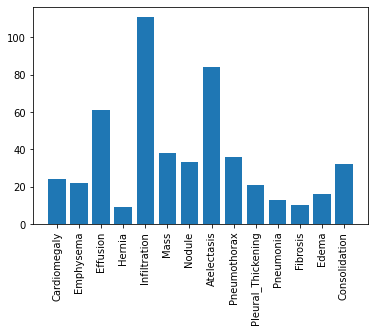

In [74]:
plt.xticks(rotation=90)
plt.bar(x = labels, height= y.sum(axis=0));

In [75]:
def true_positives(y, pred, th=0.5):
    """
    Count true positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TP (int): true positives
    """
    TP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute TP
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    
    return TP

def true_negatives(y, pred, th=0.5):
    """
    Count true negatives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TN (int): true negatives
    """
    TN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute TN
    TN = np.sum((y==0)&(thresholded_preds == 0))
    
    ### END CODE HERE ###
    
    return TN

def false_positives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FP (int): false positives
    """
    FP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # compute FP
    FP = np.sum((y==0)&(thresholded_preds == 1))
    
    ### END CODE HERE ###
    
    return FP

def false_negatives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FN (int): false negatives
    """
    FN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute FN
    FN = np.sum((y==1)&(thresholded_preds == 0))
    
    ### END CODE HERE ###
    
    return FN

In [76]:
get_performance_metrics(y, pred, labels)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,13,291,0,11,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Emphysema,9,293,0,13,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Effusion,25,253,1,36,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Hernia,7,306,0,2,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Infiltration,54,201,3,57,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Mass,13,277,0,25,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Nodule,20,282,0,13,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Atelectasis,53,229,2,31,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Pneumothorax,16,278,1,20,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5


In [77]:
def get_accuracy(y, pred, th=0.5):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        accuracy (float): accuracy of predictions at threshold
    """
    accuracy = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP, FP, TN, FN using our previously defined functions
    TP = true_positives(y,pred,th)
    FP = false_positives(y,pred,th)
    TN = true_negatives(y,pred,th)
    FN = false_negatives(y,pred,th)

    # Compute accuracy using TP, FP, TN, FN
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    
    ### END CODE HERE ###
    
    return accuracy

In [79]:
get_performance_metrics(y, pred, labels, acc=get_accuracy)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,13,291,0,11,0.965,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Emphysema,9,293,0,13,0.959,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Effusion,25,253,1,36,0.883,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Hernia,7,306,0,2,0.994,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Infiltration,54,201,3,57,0.81,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Mass,13,277,0,25,0.921,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Nodule,20,282,0,13,0.959,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Atelectasis,53,229,2,31,0.895,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Pneumothorax,16,278,1,20,0.933,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5


In [85]:
def get_prevalence(y):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
    Returns:
        prevalence (float): prevalence of positive cases
    """
    prevalence = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    prevalence = np.mean(y)
    
    ### END CODE HERE ###
    
    return prevalence

In [86]:
get_performance_metrics(y, pred, labels, acc=get_accuracy, prevalence=get_prevalence)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,13,291,0,11,0.965,0.076,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Emphysema,9,293,0,13,0.959,0.07,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Effusion,25,253,1,36,0.883,0.194,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Hernia,7,306,0,2,0.994,0.029,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Infiltration,54,201,3,57,0.81,0.352,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Mass,13,277,0,25,0.921,0.121,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Nodule,20,282,0,13,0.959,0.105,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Atelectasis,53,229,2,31,0.895,0.267,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Pneumothorax,16,278,1,20,0.933,0.114,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5


In [87]:
def get_sensitivity(y, pred, th=0.5):
    """
    Compute sensitivity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        sensitivity (float): probability that our test outputs positive given that the case is actually positive
    """
    sensitivity = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP and FN using our previously defined functions
    FN = false_negatives(y,pred,th)
    TP = true_positives(y,pred,th)

    # use TP and FN to compute sensitivity
    sensitivity = TP/(TP+FN)
    
    ### END CODE HERE ###
    
    return sensitivity

def get_specificity(y, pred, th=0.5):
    """
    Compute specificity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        specificity (float): probability that the test outputs negative given that the case is actually negative
    """
    specificity = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TN and FP using our previously defined functions
    FP = false_positives(y,pred,th)
    TN = true_negatives(y,pred,th)
    
    # use TN and FP to compute specificity 
    specificity = TN/(TN+FP)
    
    ### END CODE HERE ###
    
    return specificity

In [88]:
get_performance_metrics(y, pred, labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,13,291,0,11,0.965,0.076,0.542,1,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Emphysema,9,293,0,13,0.959,0.07,0.409,1,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Effusion,25,253,1,36,0.883,0.194,0.41,0.996,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Hernia,7,306,0,2,0.994,0.029,0.778,1,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Infiltration,54,201,3,57,0.81,0.352,0.486,0.985,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Mass,13,277,0,25,0.921,0.121,0.342,1,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Nodule,20,282,0,13,0.959,0.105,0.606,1,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Atelectasis,53,229,2,31,0.895,0.267,0.631,0.991,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Pneumothorax,16,278,1,20,0.933,0.114,0.444,0.996,Not Defined,Not Defined,Not Defined,Not Defined,0.5


In [89]:
def get_ppv(y, pred, th=0.5):
    """
    Compute PPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        PPV (float): positive predictive value of predictions at threshold
    """
    PPV = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP and FP using our previously defined functions
    TP = true_positives(y,pred,th)
    FP = false_positives(y,pred,th)

    # use TP and FP to compute PPV
    PPV = TP/(TP+FP)
    
    ### END CODE HERE ###
    
    return PPV

def get_npv(y, pred, th=0.5):
    """
    Compute NPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        NPV (float): negative predictive value of predictions at threshold
    """
    NPV = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TN and FN using our previously defined functions
    TN = true_negatives(y,pred,th)
    FN = false_negatives(y,pred,th)

    # use TN and FN to compute NPV
    NPV = TN/(TN+FN)
    
    ### END CODE HERE ###
    
    return NPV

In [90]:
get_performance_metrics(y, pred, labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,13,291,0,11,0.965,0.076,0.542,1,1,0.964,Not Defined,Not Defined,0.5
Emphysema,9,293,0,13,0.959,0.07,0.409,1,1,0.958,Not Defined,Not Defined,0.5
Effusion,25,253,1,36,0.883,0.194,0.41,0.996,0.962,0.875,Not Defined,Not Defined,0.5
Hernia,7,306,0,2,0.994,0.029,0.778,1,1,0.994,Not Defined,Not Defined,0.5
Infiltration,54,201,3,57,0.81,0.352,0.486,0.985,0.947,0.779,Not Defined,Not Defined,0.5
Mass,13,277,0,25,0.921,0.121,0.342,1,1,0.917,Not Defined,Not Defined,0.5
Nodule,20,282,0,13,0.959,0.105,0.606,1,1,0.956,Not Defined,Not Defined,0.5
Atelectasis,53,229,2,31,0.895,0.267,0.631,0.991,0.964,0.881,Not Defined,Not Defined,0.5
Pneumothorax,16,278,1,20,0.933,0.114,0.444,0.996,0.941,0.933,Not Defined,Not Defined,0.5


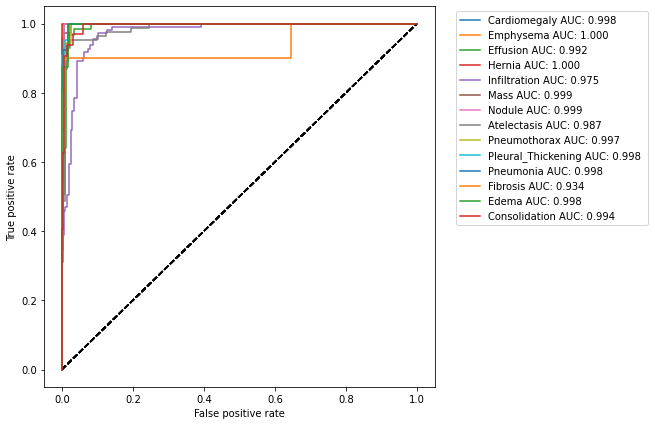

In [91]:
get_curve(y, pred, labels)

In [92]:
from sklearn.metrics import roc_auc_score
get_performance_metrics(y, pred, labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,13,291,0,11,0.965,0.076,0.542,1,1,0.964,0.998,Not Defined,0.5
Emphysema,9,293,0,13,0.959,0.07,0.409,1,1,0.958,1,Not Defined,0.5
Effusion,25,253,1,36,0.883,0.194,0.41,0.996,0.962,0.875,0.992,Not Defined,0.5
Hernia,7,306,0,2,0.994,0.029,0.778,1,1,0.994,1,Not Defined,0.5
Infiltration,54,201,3,57,0.81,0.352,0.486,0.985,0.947,0.779,0.975,Not Defined,0.5
Mass,13,277,0,25,0.921,0.121,0.342,1,1,0.917,0.999,Not Defined,0.5
Nodule,20,282,0,13,0.959,0.105,0.606,1,1,0.956,0.999,Not Defined,0.5
Atelectasis,53,229,2,31,0.895,0.267,0.631,0.991,0.964,0.881,0.987,Not Defined,0.5
Pneumothorax,16,278,1,20,0.933,0.114,0.444,0.996,0.941,0.933,0.997,Not Defined,0.5


In [94]:
def bootstrap_auc(y, pred, classes, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))

    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = roc_auc_score(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

statistics = bootstrap_auc(y, pred, labels)

In [95]:
print_confidence_intervals(labels, statistics)

,Mean AUC (CI 5%-95%)
Cardiomegaly,1.00 (1.00-1.00)
Emphysema,1.00 (1.00-1.00)
Effusion,0.99 (0.99-1.00)
Hernia,1.00 (1.00-1.00)
Infiltration,0.98 (0.97-0.98)
Mass,1.00 (1.00-1.00)
Nodule,1.00 (1.00-1.00)
Atelectasis,0.99 (0.98-0.99)
Pneumothorax,1.00 (0.99-1.00)
Pleural_Thickening,1.00 (1.00-1.00)


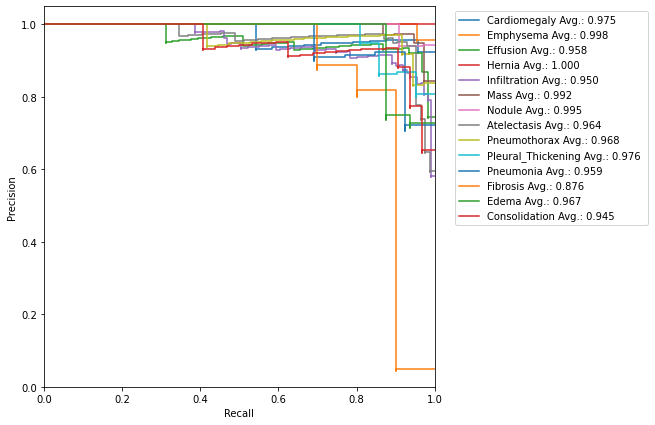

In [97]:
get_curve(y, pred, labels, curve='prc')

In [98]:
from sklearn.metrics import f1_score
get_performance_metrics(y, pred, labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,13,291,0,11,0.965,0.076,0.542,1,1,0.964,0.998,0.703,0.5
Emphysema,9,293,0,13,0.959,0.07,0.409,1,1,0.958,1,0.581,0.5
Effusion,25,253,1,36,0.883,0.194,0.41,0.996,0.962,0.875,0.992,0.575,0.5
Hernia,7,306,0,2,0.994,0.029,0.778,1,1,0.994,1,0.875,0.5
Infiltration,54,201,3,57,0.81,0.352,0.486,0.985,0.947,0.779,0.975,0.643,0.5
Mass,13,277,0,25,0.921,0.121,0.342,1,1,0.917,0.999,0.51,0.5
Nodule,20,282,0,13,0.959,0.105,0.606,1,1,0.956,0.999,0.755,0.5
Atelectasis,53,229,2,31,0.895,0.267,0.631,0.991,0.964,0.881,0.987,0.763,0.5
Pneumothorax,16,278,1,20,0.933,0.114,0.444,0.996,0.941,0.933,0.997,0.604,0.5


In [99]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y, pred):
    plt.figure(figsize=(20, 20))
    for i in range(len(labels)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:,i], pred[:,i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(labels[i])
    plt.tight_layout()
    plt.show()

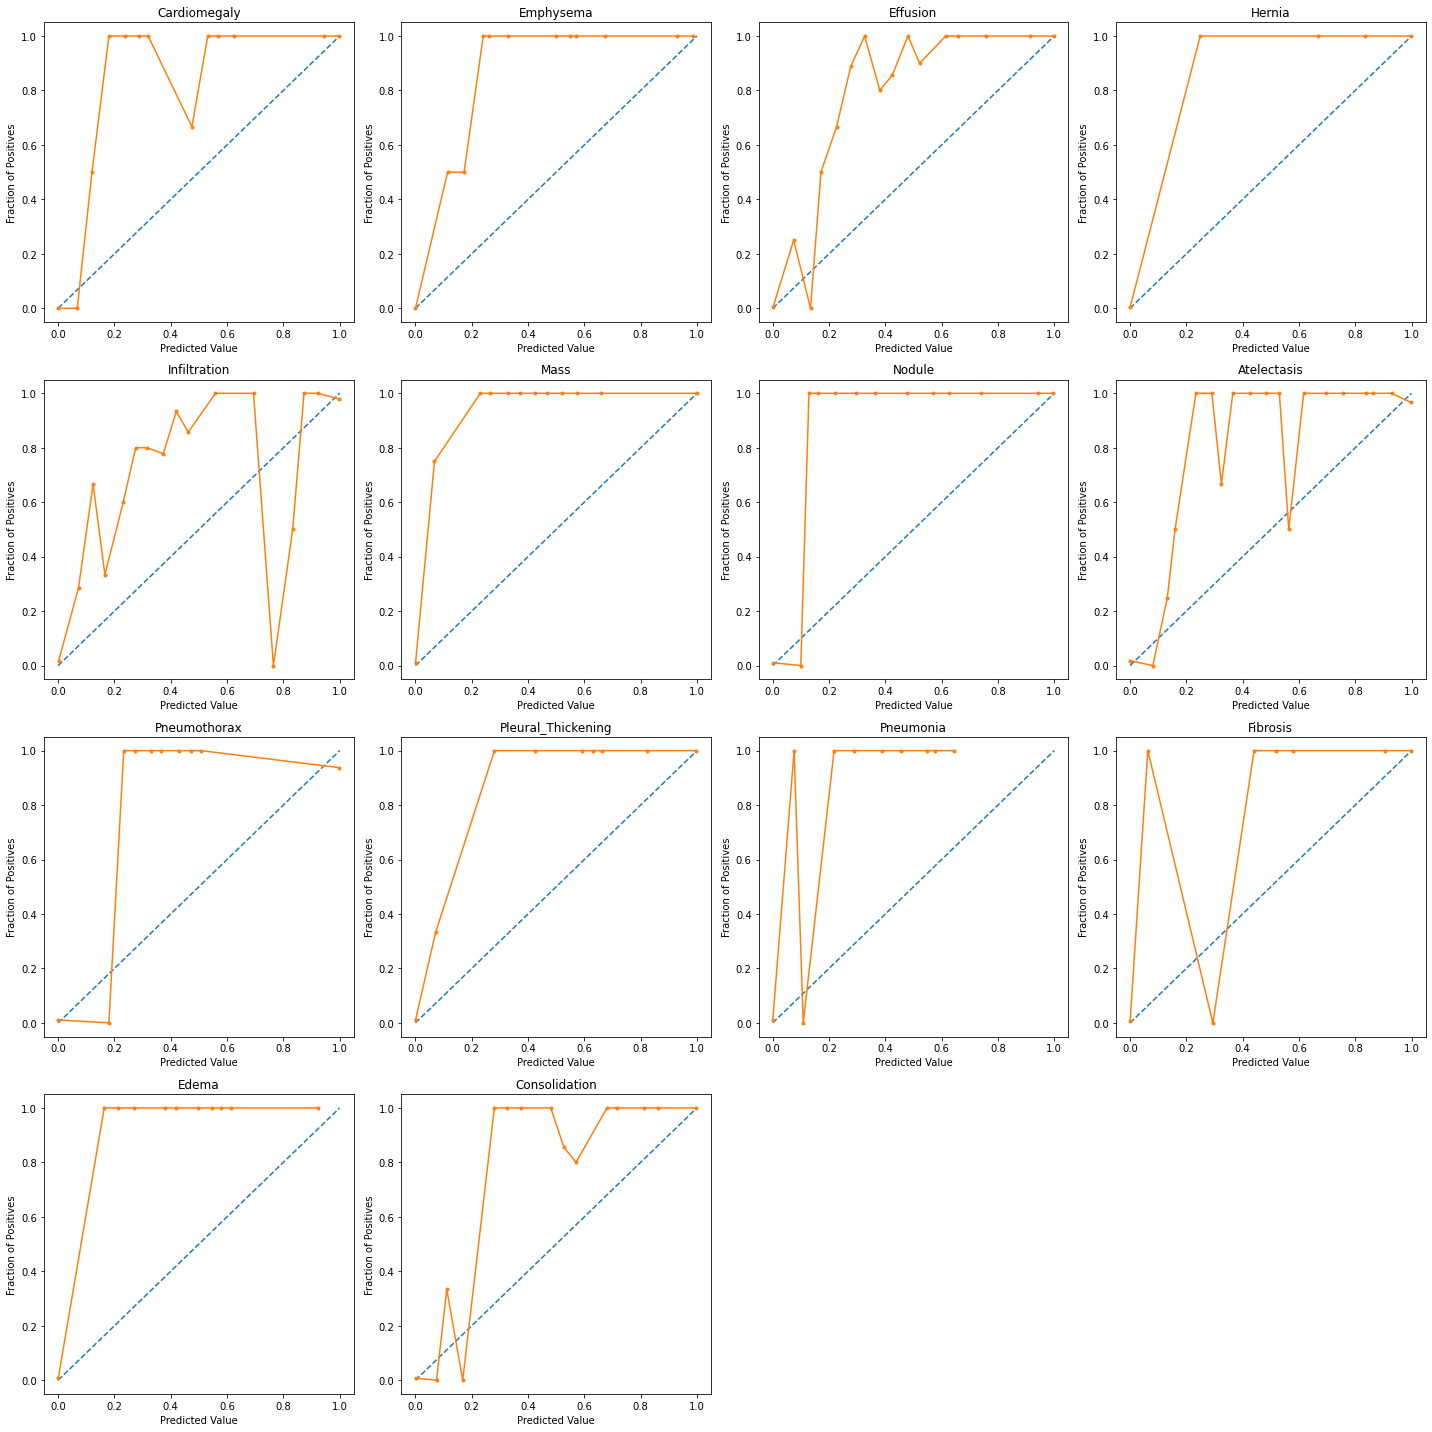

In [100]:
plot_calibration_curve(y, pred)

In [143]:
from sklearn.linear_model import LogisticRegression as LR 

y_train = final_df_train[labels].values
pred_train = final_df_train[pred_labels].values
pred_calibrated = np.zeros_like(pred)

for i in range(len(labels)):
    lr = LR(solver='liblinear', max_iter=10000)
    lr.fit(pred_train[:, i].reshape(-1, 1), y_train[:, i])    
    pred_calibrated[:, i] = lr.predict_proba(pred[:, i].reshape(-1, 1))[:,1]

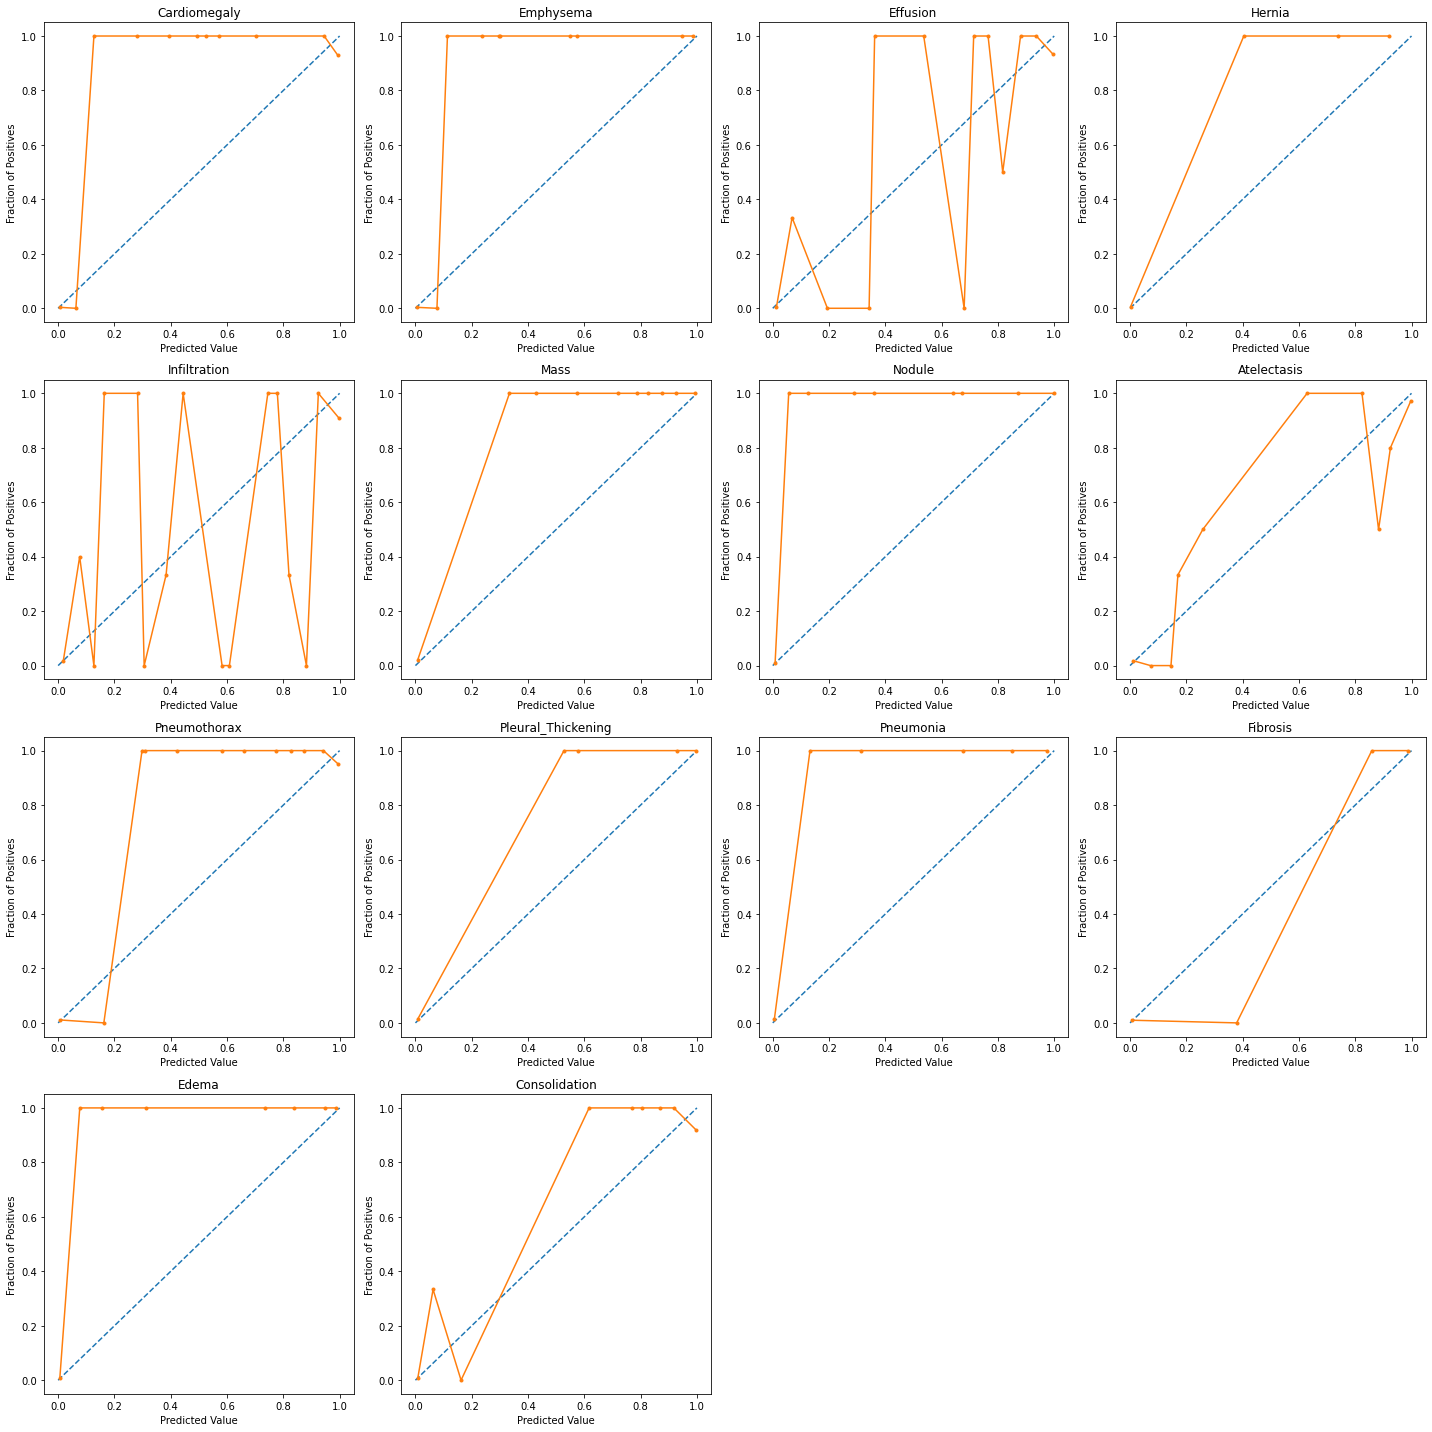

In [144]:
plot_calibration_curve(y[:,], pred_calibrated)